In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# utility function
def util(c, gamma):
    return (np.maximum(c, 1e-8)**(1 - gamma)) / (1 - gamma) if gamma != 1 else np.log(np.maximum(c, 1e-8))

# setting parameters
gamma = 2.0                # 相対的リスク回避度
beta = 0.96                # 割引因子
r = 0.04                   # 利子率
R = 1 + r                  # 資本収益率
JJ = 3                     # 3期間モデルに統一
l = np.array([0.6, 1.0, 1.5])  # 生産性の高低（統一）
NL = len(l)

prob = np.array([          # 生産性の遷移確率（マルコフ連鎖）
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1361],
    [0.0021, 0.2528, 0.7451]
])

# making grids
a_l = 0.0
a_u = 6.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initiallization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))
c = np.zeros((JJ, NA, NL))

# backward induction term3
for ia in range(NA):
    for il in range(NL):
        v[JJ-1, ia, il] = util(R * a[ia], gamma)
        aplus[JJ-1, ia, il] = 0.0
        c[JJ-1, ia, il] = R * a[ia]

# backward induction term2,1
for ij in range(JJ-2, -1, -1):
    for il in range(NL):
        for ia in range(NA):
            reward = np.full(NA, -np.inf)
            for iap in range(NA):
                EV = 0.0
                for ilp in range(NL):
                    EV += prob[il, ilp] * v[ij+1, iap, ilp]

                cons = l[il] + R * a[ia] - a[iap]
                if cons > 0:
                    reward[iap] = util(cons, gamma) + beta * EV

            i_star = np.argmax(reward)
            iaplus[ij, ia, il] = i_star
            aplus[ij, ia, il] = a[i_star]
            c[ij, ia, il] = l[il] + R * a[ia] - aplus[ij, ia, il]
            v[ij, ia, il] = reward[i_star]

mu = np.zeros((JJ, NA, NL))
mu[0, 0, :] = 1.0 / NL
for ij in range(JJ - 1):
    for il in range(NL):
        for ia in range(NA):
            iap = iaplus[ij, ia, il]
            for ilp in range(NL):
                mu[ij + 1, iap, ilp] += prob[il, ilp] * mu[ij, ia, il]

policy_a2 = aplus[0, :, :]  # shape: (NA, NL)

In [ ]:
# ———— 問２：中年期に30%課税して老年期に一律年金を給付 ————

# 税率の設定
tax_rate = 0.30

# 1) 中年期（ij = 1）の総税収を計算
# mu[1, ia, il]：中年期における「資産グリッド ia × 生産性 il」の人口比率
# l[il]        ：その生産性タイプの労働所得
tax_total = tax_rate * np.sum(mu[1, :, :] * l[None, :])

# 2) 老年期（ij = 2）の全人口を集計
total_elderly = np.sum(mu[2, :, :])

# 3) 税収を利子付きで運用し、一人当たり給付額を計算
pension_per_person = (1 + r) * tax_total / total_elderly

# 結果を表示
print(f"中年期の総税収            = {tax_total:.5f}")
print(f"老年期一人当たり年金給付額 = {pension_per_person:.5f}")


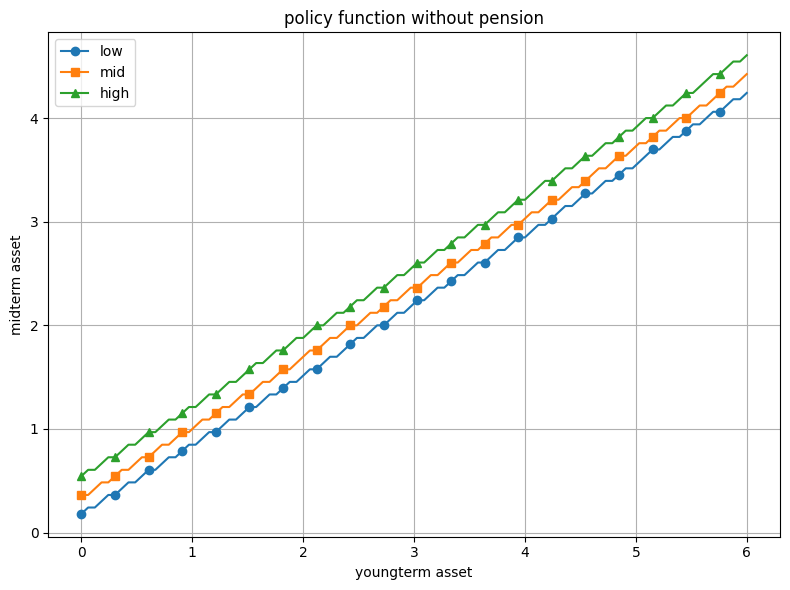

In [ ]:
# ———— 問３：年金導入後の再最適化と政策関数の比較 ————

labels  = ['low', 'mid', 'high']
markers = ['o', 's', '^']
colors  = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(8, 6))
for il in range(NL):
    plt.plot(
        a,
        policy_a2[:, il],           # aplus[0,:,il] と同じ
        color=colors[il],           # 線と凡例の色
        marker=markers[il],         # マーカー形状
        markevery=5,                # 5点ごとに表示
        label=labels[il]            # 凡例ラベル
    )

plt.xlabel('youngterm asset')
plt.ylabel('midterm asset')
plt.title('policy function without pension')
plt.grid(True)
plt.legend(loc='upper left')      # 凡例を左上に
plt.tight_layout()
plt.show()


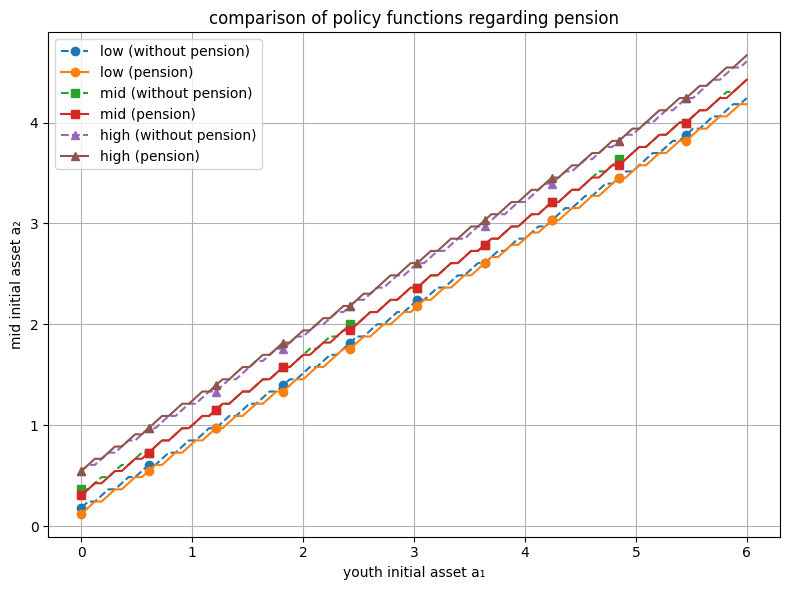

In [ ]:
#consider tax
tax_rate = 0.30
tax_total = tax_rate * np.sum(mu[1, :, :] * l[None, :])

total_elderly = np.sum(mu[2, :, :])
pension_per_person = (1 + r) * tax_total / total_elderly

import numpy as np
import matplotlib.pyplot as plt

#initiallization
v_p     = np.zeros((JJ, NA, NL))
iaplus_p= np.zeros((JJ, NA, NL), dtype=int)
aplus_p = np.zeros((JJ, NA, NL))
c_p     = np.zeros((JJ, NA, NL))

#consider the pension
for ia in range(NA):
    for il in range(NL):
        cons = R * a[ia] + pension_per_person
        v_p[JJ-1, ia, il] = util(cons, gamma)
        aplus_p[JJ-1, ia, il] = 0.0
        c_p[JJ-1, ia, il] = cons

#introduce revenue income
for ij in range(JJ-2, -1, -1):
    for il in range(NL):
        for ia in range(NA):
            reward = np.full(NA, -np.inf)
            for iap in range(NA):
                # 期待値計算
                EV = 0.0
                for ilp in range(NL):
                    EV += prob[il, ilp] * v_p[ij+1, iap, ilp]
                # 税引き後所得
                income = l[il] * (1 - tax_rate) if ij == 1 else l[il]
                cons = income + R * a[ia] - a[iap]
                if cons > 0:
                    reward[iap] = util(cons, gamma) + beta * EV

            i_star = np.argmax(reward)
            iaplus_p[ij, ia, il] = i_star
            aplus_p[ij, ia, il]  = a[i_star]
            c_p[ij, ia, il]      = income + R * a[ia] - aplus_p[ij, ia, il]
            v_p[ij, ia, il]      = reward[i_star]

#  policy function
policy_no_pension = policy_a2        # aplus[0, :, :]
policy_with_pension = aplus_p[0, :, :]

# plot
labels  = ['low', 'mid', 'high']
markers = ['o', 's', '^']
plt.figure(figsize=(8,6))
for il in range(NL):
    # 年金なし
    plt.plot(a, policy_no_pension[:, il],
             linestyle='--', marker=markers[il], markevery=10,
             label=f'{labels[il]} (without pension)')
    # 年金あり
    plt.plot(a, policy_with_pension[:, il],
             linestyle='-', marker=markers[il], markevery=10,
             label=f'{labels[il]} (pension)')

plt.xlabel('youth initial asset a₁')
plt.ylabel('mid initial asset a₂')
plt.title('comparison of policy functions regarding pension')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ———— 問４：平均期待生涯効用の計算 ————

# initial asset
ia0 = 0

# （1）without pension
util_no_pension = np.sum(mu[0, ia0, :] * v[0, ia0, :])

# （2）pension
util_with_pension = np.sum(mu[0, ia0, :] * v_p[0, ia0, :])

# result
print(f"without pension average expected utility = {util_no_pension:.5f}")
print(f"pension average expected utility  = {util_with_pension:.5f}")

# judge
if util_with_pension > util_no_pension:
    print("→ utility increases")
else:
    print("→ utility decreases")


without pension average expected utility = -4.65402
pension average expected utility  = -4.48656
→ utility increases
